In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score ,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


In [16]:
def split_data(df, target_column, test_size=0.2, random_state=None,downsample=False):
    # Convert 'YES'/'NO' to binary
    df[target_column] = df[target_column].map({'YES': 1, 'NO': 0})
    
    # Splitting each class independently
    df_yes = df[df[target_column] == 1]
    df_no = df[df[target_column] == 0]
    
    if downsample:
        # df_no = df_no.sample(n=len(df_yes),random_state=random_state)
        df_yes = df_yes.sample(n=len(df_no),random_state=random_state)
    
    # print(f"NO values : {len(df_no)} , Yes Values : {len(df_yes)} ") 
    
    train_yes_X, test_yes_X, train_yes_y, test_yes_y = train_test_split(
        df_yes.loc[:, df_yes.columns != target_column], df_yes[target_column], 
        test_size=test_size, random_state=random_state)
    
    train_no_X, test_no_X, train_no_y, test_no_y = train_test_split(
        df_no.loc[:, df_no.columns != target_column], df_no[target_column], 
        test_size=test_size, random_state=random_state)
    
    # Combine the splits from both classes
    train_X = pd.concat([train_yes_X, train_no_X])
    train_y = pd.concat([train_yes_y, train_no_y])
    test_X = pd.concat([test_yes_X, test_no_X])
    test_y = pd.concat([test_yes_y, test_no_y])
    
    # Shuffle the combined splits as they are currently sorted by class
    train_X, train_y = shuffle(train_X, train_y, random_state=random_state)
    test_X, test_y = shuffle(test_X, test_y, random_state=random_state)
    
    # Create the dictionary of dictionaries
    data = {
        'train': {'X': train_X, 'y': train_y},
        'test': {'X': test_X, 'y': test_y}
    }
    
    data['train']['X'] = data['train']['X'].set_index('Chromosome_Start_Ref_Alt').to_numpy()
    
    data['test']['X'] = data['test']['X'].set_index('Chromosome_Start_Ref_Alt').to_numpy()
    
    
    data['train']['y'] = data['train']['y'].to_numpy() 
    data['test']['y'] = data['test']['y'].to_numpy()
    
    return data


In [17]:
def fit_models_and_plot_auc_I(run_id=1):
    
    models = {
        'LogisticRegression': LogisticRegression(class_weight='balanced',max_iter=1000),
        'SVC': SVC(kernel='linear'), 
        'RandomForestClassifier': RandomForestClassifier()
    }
    
    df_yes = pd.read_csv('raw_data/label_YES/Mutation_299_Yes_40scores_2936_feb8.txt', delimiter='\t')
    chromosome_ref_name = df_yes['Chromosome_Start_Ref_Alt']
    del df_yes['Chromosome_Start_Ref_Alt']

    df_yes.replace('.', np.nan, inplace=True)
    df_yes = df_yes.apply(pd.to_numeric, errors='coerce')
    df_yes.fillna(df_yes.mean(), inplace=True)
    df_yes['Status'] = 'YES'
    df_yes['Chromosome_Start_Ref_Alt'] = chromosome_ref_name

    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc': []}
    coefficients = {}
    feature_importances = []
    cdf = {}

    df_no_path = f'./raw_data/label_NO/Iteration{run_id}_2936-No.txt'
    df_no = pd.read_csv(df_no_path, delimiter='\t')
    temp1 = df_no['Chromosome_Start_Ref_Alt']
    del df_no['Chromosome_Start_Ref_Alt']
    df_no.replace('.', np.nan, inplace=True)
    df_no = df_no.apply(pd.to_numeric, errors='coerce')
    df_no.fillna(df_no.mean(), inplace=True)
    df_no['Status'] = 'NO'
    df_no['Chromosome_Start_Ref_Alt'] = temp1
    
    df_combined = pd.concat([df_yes, df_no], axis=0)
    
    temp_data = split_data(df_combined, 'Status', random_state=run_id)
    X_train, y_train = temp_data['train']['X'], temp_data['train']['y']
    X_test, y_test = temp_data['test']['X'], temp_data['test']['y']
    
    for name, model in models.items():
        cdf[name] = {};
        model.fit(X_train, y_train)
    
        # Check if the model has predict_proba, otherwise use decision_function if available
        # We require y_scores so that we can plot the AUC curve.
        # Ideally y_pred is used as final prediction 
        
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
            print(f'model name(predict_proba) :{name}')
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
            # Normalize decision_function output to be between 0 and 1
            y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
        else:
            raise ValueError(f"Model {name} does not have predict_proba or decision_function")
            
        y_pred = model.predict(X_test)
        print(f'Model name {model}' ,y_scores.shape)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_scores) 
        cdf[name]['X_fpr'],cdf[name]['Y_tpr'],cdf[name]['threshold']  = fpr, tpr, thresholds;

        roc_auc = roc_auc_score(y_test, y_pred,average='weighted')
        cdf[name]['ROC_AUC_value'] = roc_auc 
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        y_pred_class = y_scores >= 0.5 


    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    return cdf

model name(predict_proba) :LogisticRegression
Model name LogisticRegression(class_weight='balanced', max_iter=1000) (1176,)
Model name SVC(kernel='linear') (1176,)
model name(predict_proba) :RandomForestClassifier
Model name RandomForestClassifier() (1176,)


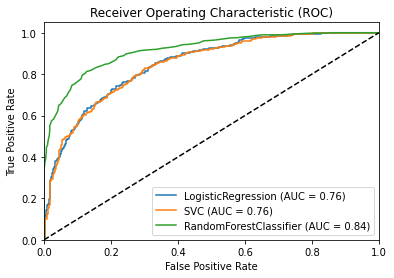

In [18]:
data_r1 = fit_models_and_plot_auc_I(run_id=1)